# Literature

$[1]$ --- Implementable tensor methods in unconstrained convex optimization, https://alfresco.uclouvain.be/alfresco/service/guest/streamDownload/workspace/SpacesStore/aabc2323-0bc1-40d4-9653-1c29971e7bd8/coredp2018_05web.pdf?guest=true.

$[2]$ ---  Cubic regularization of Newton method and its global performance, http://lab7.ipu.ru/files/polyak/Nest_Pol-MathProg'06.pdf.

$[3]$ --- Acelerating the cubic regularization of Newton’s method on convex
problems, http://webdoc.sub.gwdg.de/ebook/serien/e/CORE/dp2005_68.pdf.

$[4]$ --- A.R. Conn, N.I. M. Gould, and Ph.L. Toint. Trust Region Methods. SIAM, Philadelphia, 2000.

$[5]$ --- Анализ быстрого градиентного метода Нестерова для задач машинного обучения с $L_1$-регуляризацией, http://www.machinelearning.ru/wiki/images/0/03/Rodomanov_FGM.pdf.

# Purpose of code: compute methods $[1]$.$[2.16]$ and $[1]$.$[3.12]$ with $p = 2$ by testing on $[1]$.$[4.3]$ with $n = 1000$ 

##### Import libraries

In [1]:
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize_scalar, minimize
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    
from autograd import jacobian
from numpy import linalg, loadtxt
import math
import autograd.scipy as scipy
from scipy import optimize
import copy

##### Generation matrix $A_k$ for function $f_k(x)$ in $[1]$.$[4.3]$ by Yu. Nesterov (2018).

In [2]:
def generateAUI(k, n):
    U = np.zeros((k, k))
    I = np.eye(n - k)
    for i in range(k):
        U[i][i] = 1
        if (i + 1 < k):
            U[i][i + 1] = -1
    Ak = np.block([[U, np.zeros((k, n - k))], [np.zeros((n - k, k)), I]])        
    return Ak    

##### $f_k$ in $[1]$.$[4.3]$, its minimum and gradient, hessian and third derivative using autograd and closed-form expressions.

In [3]:
def f(x, *args):
    k, n, p = args
    Ak = generateAUI(k, n)

    # Universal bad function
    Axk = np.dot(Ak, x)
    sum_Axk = np.sum(np.power(np.abs(Axk), p + 1))/(p + 1)
    return sum_Axk - x[0]

def x_opt_f(*args):
    k, n, p = args
    x_opt = np.zeros(n)
    for i in range(1, k + 1):
        x_opt[i - 1] = k - i + 1
    return x_opt

def f_opt(*args):
    k, n, p = args
    return -k*p/(p + 1)

grad_f = grad(f)       # Obtain its gradient function      

hess_f = jacobian(grad_f) # Obtain its hessian function 

tensor3_f = jacobian(hess_f) # Obtain its third derivative function 

def grad_f_true(x, *args):
    k, n, p = args
    Ak = generateAUI(k, n)
    arg_eta = np.dot(Ak, x)
    arg_eta_abs = (np.abs(arg_eta)**(p - 1))*arg_eta
    grad_ans = np.dot(Ak.T, arg_eta_abs)
    grad_ans[0] -= 1
    return grad_ans

def hess_f_true(x, *args):
    k, n, p = args
    Ak = generateAUI(k, n)
    arg_eta = np.dot(Ak, x)
    arg_eta_abs = p*(np.abs(arg_eta)**(p - 1))
    return np.dot(arg_eta_abs * Ak.T, Ak)

def tensor3_f_true(x, *args):
    k, n, p = args
    Ak = generateAUI(k, n)
    arg_eta = np.dot(Ak, x)
    arg_eta_abs = p*(p - 1)*(np.abs(arg_eta)**(p - 3))*arg_eta
    return np.einsum("i,im,il,it->mlt", arg_eta_abs, Ak, Ak, Ak)

def dot_tensor3_vect_vect_f_true(x, h, *args):
    k, n, p = args
    Ak = generateAUI(k, n)
    arg_eta = np.dot(Ak, x)
    arg_eta_abs = p*(p - 1)*(np.abs(arg_eta)**(p - 3))*arg_eta
    return sum([arg_eta_abs[i]*((np.dot(Ak[i], h))**2)*Ak[i] for i in range(n)])

##### Upper bounds on $L_p(f_k)$ for $f_k$ in $[1]$.$[4.3]$.

In [4]:
def generateU(k):
    U = np.zeros((k, k))
    for i in range(k):
        U[i][i] = 1
        if (i + 1 < k):
            U[i][i + 1] = -1
    return U

def Ak_2_norm(k, n):
    Uk = generateU(k)
    Uk_singular = np.dot(Uk.T, Uk)
    E, V = linalg.eigh(Uk_singular) 
    lambda_max = max(E)
    Uk_2_norm = lambda_max**0.5
    if (n - k > 0):
        return max(1, Uk_2_norm)
    else:
        return Uk_2_norm
    
def Lp_2_norm_real(*args):
    k, n, p = args
    return math.factorial(p)*((Ak_2_norm(k, n))**(p + 1))

def Lp_2_norm_upper_bound_real(*args):
    k, n, p = args
    return math.factorial(p)*(2**(p + 1))

def Lp_2_norm_Nesterov(*args):
    k, n, p = args
    return math.factorial(p)*((Ak_2_norm(k, n))**p)

def Lp_2_norm_upper_bound_Nesterov(*args):
    k, n, p = args
    return math.factorial(p)*(2**p)

def Lp_2_norm_stupid(*args):
    k, n, p = args
    return math.factorial(p)*2

def L2_upper_bound(L3, x0, *args):
    return L3 * 2*linalg.norm(x0 - x_opt_f(*args))

#k = 3
#Uk = generateU(k)
#Uk_singular = np.dot(Uk.T, Uk)
#E,V = linalg.eigh(Uk_singular) 
#lambda_max = max(E)
#Ak_norm = Ak_2_norm(5, 6)

#print(Uk_singular)
#print(E)
#print(Ak_norm)
#p = 3
#k = 50
#n = 100
#print(L3_2_norm(k, n, p))

##### Calculation parameters $c, A \succeq 0, \gamma > 0$ for auxiliary minimization problem $[1]$.$[5.8]$ in terms of problem 
$$
\langle c, h \rangle + \frac{1}{2}\langle Ah, h \rangle + \frac{\gamma}{4}||h||_2^4 \rightarrow \min\limits_{h \in \mathbb{R}^n}
$$ 

In [5]:
def calc_cur_params(grad_f_cur, hessian_f_cur, tensor3_f_cur_vect, hk, tau, L):
    grad_d = np.dot(hk, hk.T)*hk
    c = (grad_f_cur - 1/tau*np.dot(hessian_f_cur, hk.T) + 0.5*tensor3_f_cur_vect 
                                                                        - tau*(tau + 1)/2*L*grad_d) + tau*tau*L/2*grad_d
    
    A = (tau + 1) / tau * hessian_f_cur
    
    gamma = tau*(tau + 1)/2*L
    return c, A, gamma

##### Objective function $f_{c, A, \gamma}(h) = \langle c, h \rangle + \frac{1}{2}\langle Ah, h \rangle + \frac{\gamma}{4}||h||_2^4$ for auxiliary minimization problem $[1]$.$[5.8]$ and its univariate dual function $g_{c, A, \gamma}(\tau) = \frac{1}{2}\tau^2 + \frac{1}{2}\Bigl\langle \bigl(\sqrt{2\gamma}\tau B + A\bigr)^{-1}c, c \Bigr\rangle$ with $B = I_{n \times n}$ for Euclid 2-norm.

In [6]:
def aux_problem_func(h, *args):
    c, A, gamma = args
    d = linalg.norm(h)
    d4 = d*d*d*d
    return np.dot(c, h) + 0.5 * np.dot(np.dot(A, h), h) + 0.25*gamma*d4 

def aux_problem_onedim_func(tau, *args):
    c, A, B, gamma = args
    sgam = math.sqrt(2*gamma)
    S = sgam*tau*B + A
    invS = linalg.inv(S)
    f = 0.5*tau*tau + 0.5 * np.dot(np.dot(invS, c), c)
    
    return f

##### Calculation minimum of $f_{c, A, \gamma}(h)$ using minimum of dual function $g_{c, A, \gamma}(\tau)$.

In [7]:
def calc_hopt(t, *args):
    c, A, B, gamma = args
    S = math.sqrt(2*gamma)*t*B + A
    invS = linalg.inv(S)
    h_opt = -np.dot(invS, c)
    return h_opt

##### Newton's method for finding minimum $g_{c, A, \gamma}(\tau)$ based on $[4]$, Chapter $7$.

The main idea is to find root $\lambda > 0$ of first-order optimality condition: $\sqrt{\lambda} = ||s(\lambda)||_2, s(\lambda) = -(A + \lambda I)^{-1}c_{\text{new}}, \lambda = \sqrt{2\gamma}\tau, c_{\text{new}} = \sqrt{\gamma}c$.

It is better to solve the secular equation:
$$
\phi(\lambda) = \frac{1}{||s(\lambda)||_{2}} - \frac{1}{\sqrt{\lambda}}.
$$
So 
$$
\phi^{'}(\lambda) = \frac{\bigl \langle s(\lambda), A(\lambda)^{-1}s(\lambda) \bigr \rangle}{||s(\lambda)||_2^3} + \frac{1}{2\lambda^{\frac{3}{2}}} \geq 0, A(\lambda) = A + \lambda I;
$$
$$
\phi^{''}(\lambda) = \frac{3\Bigl(\bigl \langle s(\lambda), \nabla_{\lambda}s(\lambda) \bigr \rangle^2 - ||s(\lambda)||_2^2||\nabla_{\lambda}s(\lambda)||_2^2\Bigr)}{||s(\lambda)||_2^5} - \frac{3}{4\lambda^{\frac{5}{2}}} < 0
$$ by Cauchy-Schwartz inequality.

Newton's method for finding a root of the scalar equation $\phi(\lambda) = 0$ replaces  the estimate $\lambda_k > 0$ with the improved estimate $\lambda_{k + 1}$ for which
$$
\lambda_{k + 1} = \lambda_k - \frac{\phi(\lambda_k)}{\phi^{'}(\lambda_k)}.
$$
Using Cholesky factors $A(\lambda) = L(\lambda)L^T(\lambda)$ we can write:
$$
\bigl \langle s, A(\lambda)^{-1}s \bigr \rangle = \bigl \langle s, L^{-T}L^{-1}s \bigr \rangle = \bigl \langle L^{-1}s, L^{-1}s \bigr \rangle = ||w(\lambda)||_2^2
$$
with $w(\lambda) = L^{-1}(\lambda)s(\lambda)$.
The complete Newton algorithm is:
$$
\lambda_{k + 1} = \lambda_k \cdot \Bigl(1 - 2||s(\lambda_k)||_2^2\frac{\sqrt{\lambda_k} - ||s(\lambda_k)||_2}{||s(\lambda_k)||_2^3 + 2||w(\lambda_k)||_2^2\lambda_k^{\frac{3}{2}}}\Bigr) 
$$ while $\lambda_{k + 1} > 0$.

In [8]:
def Newton_step_tensor3(AuxMaxIter, *args):
    c, H, gamma, eps = args
    c_new = c*(gamma**0.5)
    lambda_ans = eps
    k = 0
    while (k < AuxMaxIter):
        H_lambda = H + lambda_ans*np.identity(H.shape[0])
        try:
            L = linalg.cholesky(H_lambda)
        except np.linalg.LinAlgError:
            break
        s = linalg.solve(H_lambda, -c_new)
        w = linalg.solve(L, s)
        lambda_next = lambda_ans*(1 - 
            2*(lambda_ans**0.5 - linalg.norm(s))*(linalg.norm(s)**2)/
                                  (linalg.norm(s)**3 + 2*(linalg.norm(w)**2)*(lambda_ans**(1.5))))
        if (lambda_next > 0):
            lambda_ans = lambda_next
        else:
            break
        k += 1
    #tau_opt2 = 0
    h_opt1 = -np.dot(linalg.inv(H + lambda_ans*np.identity(H.shape[0])), c)
    #h_opt2 = -np.dot(linalg.pinv(H), c)
    #val_1 = np.dot(c, h_opt1) + 1/2*np.dot(np.dot(H, h_opt1), h_opt1) + gamma/4*(linalg.norm(h_opt1)**4)
    #val_2 = np.dot(c, h_opt2) + 1/2*np.dot(np.dot(H, h_opt2), h_opt2) + gamma/4*(linalg.norm(h_opt2)**4)
    #if (val_1 < val_2):
     #   h_opt = h_opt1
    #else:
      #  h_opt = h_opt2
    #return h_opt
    return h_opt1

##### Iteration of process $[1].[5.8]$ to solve auxiliary minimization problem $[1]$.$[5.4]$.

In [9]:
def T3M(x, aux_prob_method, grad_f_cur, hess_f_cur, tensor3_f_direct, TensorMaxIter, AuxMaxIter, tau, L, eps, *args):
    
    n = x.shape[0]
    hk = np.zeros(n)
    B = np.eye(n)
 
    if aux_prob_method == 1:
        xb = L*1e10
        t0 = 0+eps
    
    for aux_k in range(1, TensorMaxIter + 1):
        tensor3_f_cur_vect = tensor3_f_direct(x, hk, *args)
        c, A, gamma = calc_cur_params(grad_f_cur, hess_f_cur, tensor3_f_cur_vect, hk, tau, L)
            
        if aux_prob_method == 1:
            allargs = (c, A, B, gamma)

            res = optimize.minimize_scalar(aux_problem_onedim_func, args = allargs, method = 'bounded', bounds=(t0, xb), 
                                                options={'xatol': eps, 'maxiter': AuxMaxIter, 'disp': False})
            
            tau_opt = res.x
            
            h_opt = calc_hopt(tau_opt, *(c, A, B, gamma))
                
        elif aux_prob_method == 2:
            allargs = (c, A, gamma)
        
            res = optimize.minimize(aux_problem_func, args = allargs, tol = eps, x0 = hk, method = 'Powell', 
                                                options={'ftol': eps,'maxiter': AuxMaxIter, 'disp': False})                
            h_opt = res.x
                
        elif aux_prob_method == 3:
            h_opt = Newton_step_tensor3(AuxMaxIter, *(c, A, gamma, eps))
        hk = h_opt
    return (hk + x)      

##### Tensor method $[1]$.$[2.16]$ by Yu. Nesterov (2018), $p = 3$
Parameters:  
$NumIter$ --- max number of steps in tensor method.

$TensorMaxIter$ --- max number of iterations in auxiliary problem solution method $[1]$.$[5.8]$.

$AuxMaxIter$ --- max number of iterations to perform step $[1]$.$[5.8]$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle.

$\langle \nabla^3 f(x) h, h \rangle$ --- objective third directional derivative of $f$ at $x$ along direction $h$ oracle .

$\tau > 1$ - parameter in $[1]$.$[5.5]$.

$L_3(f)$ - uniform bound for the Lipschitz constant of third derivative.

$\varepsilon$ - parameter to perform step $[1]$.$[5.8]$, meaning depends of $aux\_prob\_method$.

$aux\_prob\_method$ --- how to solve auxiliary problem $[1]$.$[5.4]$: $1$ --- by means of minimization $g_{c, A, \gamma}(\tau)$ using $scipy.optimize$, $2$ --- by means of minimization $f_{c, A, \gamma}(h)$ using $scipy.optimize$, $3$ --- by means of minimization $g_{c, A, \gamma}(\tau)$ using Newton's method.

$args$ - arguments for parametrization of $f$.

In [10]:
def Tensor3_iter(NumIter, TensorMaxIter, AuxMaxIter, x0, f, grad_f, hess_f, tensor3_f_direct, tau, L, eps, 
                                                             aux_prob_method, *args):
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    xk = copy.deepcopy(x0)

    for k in range(NumIter):
        f_xk = f(xk, *args)
        grad_f_xk = grad_f(xk, *args)
        hessian_f_xk = hess_f(xk, *args)
        farr[k] = f_xk
        #fgradarr[k] = linalg.norm(grad_f_xk)
        xk = T3M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, tensor3_f_direct, TensorMaxIter, AuxMaxIter,
                                                             tau, L, eps, *args) 
    
    f_xk = f(xk, *args)
    #grad_f_xk = grad_f(xk, *args)
    farr[NumIter] = f_xk
    #fgradarr[NumIter] = linalg.norm(grad_f_xk)
    
    return xk, f_xk, farr#, fgradarr
    
    

##### Prox function

In [11]:
def proxd(x, p):
    return 1. / p * (linalg.norm(x)**p) 

##### Accelerated tensor method $[1]$.$[3.12]$ by Yu. Nesterov (2018), $p = 3$

This method has additional parameter $version$ = 1 if we use formula for $A_k$ (as is $[1]$.$[3.11]$):
$$
A_k = \Bigl[\frac{(p - 1)(M^2 - L_p^2)}{4(p + 1)M^2}\Bigr]^{\frac{p}{2}}\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}
$$
and $version$ = 2 if we use formula for $A_k$:
$$
A_k = \Bigl[\frac{(p + 1)(M^2 - L_p^2)}{4(p - 1)M^2}\Bigr]^{\frac{p}{2}}\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}.
$$
Both versions use formula $[1]$.$[5.5]$:
$$
M = \tau^2 L_3.
$$

In [12]:
def TensorAcc3_iter(NumIter, TensorMaxIter, AuxMaxIter, x0, f, grad_f, hess_f, tensor3_f_direct, tau, L, eps, 
                                               aux_prob_method, version, *args):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    
    
    f_xk = f(xk, *args)
    farr[0] = f_xk
    grad_f_xk = grad_f(xk, *args)
    #fgradarr[0] = linalg.norm(grad_f_xk)
    hessian_f_xk = hess_f(xk, *args)
  
    xk = T3M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, tensor3_f_direct, TensorMaxIter, AuxMaxIter, tau, L, 
                                                                                                         eps, *args)  
    #print('xk = {0}'.format(xk))
    f_xk = f(xk, *args)
    #gradf_xk = grad_f(xk, *args)
    farr[1] = f_xk
    #fgradarr[1] = linalg.norm(gradf_xk)
    
    p = 3
    C = p / 2 * math.sqrt((p+1)/(p-1)*(M*M - L*L))
    
    min_psik = copy.deepcopy(x0)
    n = x0.shape[0]
    sk = np.zeros(n)
    if (version == 1):
        ak_part = math.sqrt(pow((p - 1) * (M*M - L*L) / 4 / (p + 1) / M / M, p))
    elif (version == 2):
        ak_part = math.sqrt(pow((p + 1) * (M*M - L*L) / 4 / (p - 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        #print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        #print('yk = {0}'.format(yk))
        grad_f_yk = grad_f(yk, *args)
        hessian_f_yk = hess_f(yk, *args)

        xk = T3M(yk, aux_prob_method, grad_f_yk, hessian_f_yk, tensor3_f_direct, TensorMaxIter, AuxMaxIter, 
                                                                                     tau, L, eps, *args)        
        #print('xk = {0}'.format(xk))
        grad_next = grad_f(xk, *args)
        a = Ak1 - Ak
        sk = sk + a * grad_next 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk, *args)
        farr[k + 1] = f_xk
        #fgradarr[k + 1] = linalg.norm(grad_next)
    
    return xk, f_xk, farr#, fgradarr, k
    

##### Objective function $v_{u}(h) = \langle g, h \rangle + \frac{1}{2}\langle Hh, h \rangle + \frac{M}{6}||h||_2^3$ for auxiliary minimization problem $[1]$.$[2.6]$ with $p = 2$ and its univariate dual function $-v_{l}(r) = \frac{M}{12}r^3 + \frac{1}{2}\Bigl\langle \bigl(H + \frac{Mr}{2}B\bigr)^{-1}g, g \Bigr\rangle$ with $B = I_{n \times n}$ for Euclid 2-norm (see $[2]$.$[5.2]$). Note that we assume $M > 0, H \succeq 0$.

In [13]:
def aux_problem_func_T2M(h, *args):
    g, H, M = args
    d = linalg.norm(h)
    d3 = d*d*d
    return np.dot(g, h) + 0.5 * np.dot(np.dot(H, h), h) + M/6*d3 

def aux_problem_onedim_func_T2M(r, *args):
    g, H, B, M = args
    sr = M*r/2
    S = sr*B + H
    invS = linalg.inv(S)
    f = M*r*r*r/12 + 0.5 * np.dot(np.dot(invS, g), g)
    
    return f

##### Calculation minimum of $v_{u}(h)$ using minimum of dual function $-v_{l}(r)$.

In [14]:
def calc_hopt_T2M(r, *args):
    g, H, B, M = args
    S = M/2*r*B + H
    invS = linalg.inv(S)
    h_opt = -np.dot(invS, g)
    return h_opt

##### Iteration of process $[1].[2.16]$ to solve auxiliary minimization problem $[1]$.$[2.6], p = 2$.

In [15]:
def T2M(x, aux_prob_method, grad_f_cur, hess_f_cur, AuxMaxIter, tau, L2, eps, *args):
    M = 2*L2*(tau**2)
    n = x.shape[0]
    hk = np.zeros(n)
    B = np.eye(n)
    if (aux_prob_method == 1):
        xb = L2*1e10
        t0 = 0+eps
        allargs = (grad_f_cur, hess_f_cur, B, M)

        res = optimize.minimize_scalar(aux_problem_onedim_func_T2M, args = allargs, method = 'bounded',
                                        bounds=(t0, xb), options={'xatol': eps, 'maxiter': AuxMaxIter, 'disp': False})
            
        r_opt = res.x
            
        h_opt = calc_hopt_T2M(r_opt, *(grad_f_cur, hess_f_cur, B, M))  
            
    if (aux_prob_method == 2):
        allargs = (grad_f_cur, hess_f_cur, M)
        
        res = optimize.minimize(aux_problem_func_T2M, args = allargs, x0 = hk, method = 'Powell', 
                                                options={'ftol': eps,'maxiter': AuxMaxIter, 'disp': False})                
        h_opt = res.x
            
    if (aux_prob_method == 3):
        h_opt = Newton_cubic_step(hk, AuxMaxIter, *(grad_f_cur, hess_f_cur, M, eps))
    
    return x + h_opt

##### Tensor method $[1]$.$[2.16]$ by Yu. Nesterov (2018), $p = 2$
With $p = 2$ we can write auxiliary problem $[1]$.$[2.6]$ as:
$$
\Omega_{x, 2, L_2}(y) = f(x) + \bigl \langle \nabla f(x), y - x \bigr \rangle + \frac{1}{2}\bigl \langle \nabla^2 f(x)(y - x), y - x \bigr \rangle + \frac{\tau^2L_2}{3}||y - x||_2^3 \rightarrow \min\limits_{y \in \mathbb{R}^n}.
$$
We used formula for $M = \tau^2L_2$ in $[1]$.$[2.16]$ as in $[1]$.$[5.5]$.

So we can solve this problem using Cubic regularization of Newton method according to work $[2]$, problem $[2]$.$[5.1]$ with $M = 2\tau^2L_2$ and $h = y - x$.

Parameters:  
$NumIter$ --- max number of steps in tensor method.

$AuxMaxIter$ --- max number of iterations to perform step $[1]$.$[2.16]$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle. 

$\tau > 1$ - parameter in formula $M = \tau^2L_2$.

$L_2(f)$ - uniform bound for the Lipschitz constant of hessian.

$\varepsilon$ - parameter to perform step $[1]$.$[2.16]$, meaning depends of $aux\_prob\_method$.

$aux\_prob\_method$ --- how to solve auxiliary problem $[1]$.$[2.6]$: $1$ --- by means of minimization $-v_l(r)$ in $[2]$.$[5.2]$ using $scipy.optimize$, $2$ --- by means of minimization $\Omega_{x, 2, L_2}(y)$ using $scipy.optimize$, $3$ --- by means of minimization $-v_l(r)$ in $[2]$.$[5.2]$ using Newton's method.

$args$ - arguments for parametrization of $f$.

In [16]:
def Tensor2_iter(NumIter, AuxMaxIter, x0, f, grad_f, hess_f, tau, L2, eps, aux_prob_method, *args):
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    xk = copy.deepcopy(x0)

    for k in range(NumIter):
        f_xk = f(xk, *args)
        grad_f_cur = grad_f(xk, *args)
        hess_f_cur = hess_f(xk, *args)
        farr[k] = f_xk
        #fgradarr[k] = linalg.norm(grad_f_xk)
        xk = T2M(xk, aux_prob_method, grad_f_cur, hess_f_cur, AuxMaxIter, tau, L2, eps, *args)
        
    f_xk = f(xk, *args)
    #grad_f_xk = grad_f(xk, *args)
    farr[NumIter] = f_xk
    #fgradarr[NumIter] = linalg.norm(grad_f_xk)
    
    return xk, f_xk, farr#, fgradarr

##### Accelerated tensor method $[1]$.$[3.12]$ by Yu. Nesterov (2018), $p = 2$
This method has additional parameter $version$ = 1 if we use formula for $A_k$ (as is $[1]$.$[3.11]$):
$$
A_k = \Bigl[\frac{(p - 1)(M^2 - L_p^2)}{4(p + 1)M^2}\Bigr]^{\frac{p}{2}}\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}
$$
and $version$ = 2 if we use formula for $A_k$:
$$
A_k = \Bigl[\frac{(p + 1)(M^2 - L_p^2)}{4(p - 1)M^2}\Bigr]^{\frac{p}{2}}\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}.
$$
Both versions use formula as in $[1]$.$[5.5]$:
$$
M = \tau^2 L_2.
$$

In [17]:
def TensorAcc2_iter(NumIter, AuxMaxIter, x0, f, grad_f, hess_f, tau, L2, eps, aux_prob_method, version, *args):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L2
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    
    
    f_xk = f(xk, *args)
    farr[0] = f_xk
    grad_f_xk = grad_f(xk, *args)
    #fgradarr[0] = linalg.norm(grad_f_xk)
    hessian_f_xk = hess_f(xk, *args)
  
    xk = T2M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, AuxMaxIter, tau, L2, eps, *args)  
    #print('xk = {0}'.format(xk))
    f_xk = f(xk, *args)
    #gradf_xk = grad_f(xk, *args)
    farr[1] = f_xk
    #fgradarr[1] = linalg.norm(gradf_xk)
    
    p = 2
    C = p / 2 * math.sqrt((p + 1)/(p - 1)*(M*M - L2*L2))
    
    min_psik = copy.deepcopy(x0)
    n = x0.shape[0]
    sk = np.zeros(n)
    if (version == 1):
        ak_part = math.sqrt(pow((p - 1) * (M*M - L2*L2) / 4 / (p + 1) / M / M, p))
    elif (version == 2):
        ak_part = math.sqrt(pow((p + 1) * (M*M - L2*L2) / 4 / (p - 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        #print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        #print('yk = {0}'.format(yk))
        grad_f_yk = grad_f(yk, *args)
        hessian_f_yk = hess_f(yk, *args)

        xk = T2M(yk, aux_prob_method, grad_f_yk, hessian_f_yk, AuxMaxIter, tau, L2, eps, *args)        
        #print('xk = {0}'.format(xk))
        grad_next = grad_f(xk, *args)
        a = Ak1 - Ak
        sk = sk + a * grad_next 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk, *args)
        farr[k + 1] = f_xk
        #fgradarr[k + 1] = linalg.norm(grad_next)
    
    return xk, f_xk, farr#, fgradarr, k

##### Newton's method for finding minimum $v_{u}(h) = \langle g, h \rangle + \frac{1}{2}\langle Hh, h \rangle + \frac{M}{6}||h||_2^3$ in $[3]$.$[5.1]$ based on one-dimensional equation $[3]$.$[5.4]$ and methods in $[4]$, Chapter $7$. Note that we assume $M > 0, H \succeq 0$.

The main idea is to find root $ \lambda_{\text{root}} > 0$ of first-order optimality condition: $\lambda = ||s(\lambda)||_2, s(\lambda) = -(H + \lambda I)^{-1}g_{\text{new}}, \lambda = \frac{M}{2}||h_{\text{opt}}||_2, g_{\text{new}} = \frac{M}{2}g, h = -(H + \lambda_{\text{root}} I)^{-1}g$.

It is better to solve the secular equation:
$$
\phi(\lambda) = \frac{1}{||s(\lambda)||_{2}} - \frac{1}{\lambda}.
$$
So 
$$
\phi^{'}(\lambda) = \frac{\bigl \langle s(\lambda), A(\lambda)^{-1}s(\lambda) \bigr \rangle}{||s(\lambda)||_2^3} + \frac{1}{\lambda^2} \geq 0, A(\lambda) = A + \lambda I;
$$
$$
\phi^{''}(\lambda) = \frac{3\Bigl(\bigl \langle s(\lambda), \nabla_{\lambda}s(\lambda) \bigr \rangle^2 - ||s(\lambda)||_2^2||\nabla_{\lambda}s(\lambda)||_2^2\Bigr)}{||s(\lambda)||_2^5} - \frac{2}{\lambda^3} < 0
$$ by Cauchy-Schwartz inequality.

Newton's method for finding a root of the scalar equation $\phi(\lambda) = 0$ replaces  the estimate $\lambda_k > 0$ with the improved estimate $\lambda_{k + 1}$ for which
$$
\lambda_{k + 1} = \lambda_k - \frac{\phi(\lambda_k)}{\phi^{'}(\lambda_k)}.
$$
Using Cholesky factors $A(\lambda) = L(\lambda)L^T(\lambda)$ we can write:
$$
\bigl \langle s, A(\lambda)^{-1}s \bigr \rangle = \bigl \langle s, L^{-T}L^{-1}s \bigr \rangle = \bigl \langle L^{-1}s, L^{-1}s \bigr \rangle = ||w(\lambda)||_2^2
$$
with $w(\lambda) = L^{-1}(\lambda)s(\lambda)$.
The complete Newton algorithm is:
$$
\lambda_{k + 1} = \lambda_k \cdot \Bigl(1 - ||s(\lambda_k)||_2^2\frac{\lambda_k - ||s(\lambda_k)||_2}{||s(\lambda_k)||_2^3 + ||w(\lambda_k)||_2^2\lambda_k^{2}}\Bigr) 
$$ while $\lambda_{k + 1} > 0$.

In [18]:
def Newton_cubic_step(x_k, NumIterStep, *args):
    g, H, M, eps = args
    g_new = g*M/2
    lambda_ans = eps
    k = 0
    while (k < NumIterStep):
        H_lambda = H + lambda_ans*np.identity(H.shape[0])
        try:
            L = linalg.cholesky(H_lambda)
        except np.linalg.LinAlgError:
            break
        s = linalg.solve(H_lambda, -g_new)
        w = linalg.solve(L, s)
        lambda_next = lambda_ans*(1 - 
            (lambda_ans - linalg.norm(s))*(linalg.norm(s)**2)/(linalg.norm(s)**3 + (linalg.norm(w)**2)*(lambda_ans**2)))
        if (lambda_next > 0):
            lambda_ans = lambda_next
        else:
            break
        k += 1
    #r_opt2 = 0
    h_opt1 = -np.dot(linalg.inv(H + lambda_ans*np.identity(H.shape[0])), g)
    h_opt = h_opt1
    #h_opt2 = -np.dot(linalg.pinv(H), g)
    #val_1 = np.dot(g, h_opt1) + 1/2*np.dot(np.dot(H, h_opt1), h_opt1) + M/6*(linalg.norm(h_opt1)**3)
    #val_2 = np.dot(g, h_opt2) + 1/2*np.dot(np.dot(H, h_opt2), h_opt2) + M/6*(linalg.norm(h_opt2)**3)
    #if (val_1 < val_2):
    #    h_opt = h_opt1
    #else:
    #    h_opt = h_opt2
    return x_k + h_opt

##### Cubic regularization of Newton method using procedure $[2]$.$[3.3]$

Parameters:  
$NumIter$ --- max number of steps in method.

$NumIterStep$ --- max number of Newton iterations to perform $Newton\_cubic\_step$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle.

$adapt$ --- $adapt = 0$ if we use nonadaptive version of algorithm $[2]$.$[3.3]$ with $M_k = L_2(f)$ and $adapt = 1$ if we use adaptive version of algorithm $[2]$.$[3.3]$ with procedure $[2]$.$[5.7]$.


$L_2(f)$ - uniform bound for the Lipschitz constant of hessian for $adapt = 0$ and $L_0$ in $[2]$.$[3.3]$ and procedure $[2]$.$[5.7]$ for $adapt = 1$.

$\varepsilon$ - initial point to perform $Newton\_cubic\_step$.



$args$ - arguments for parametrization of $f$.

In [19]:
def Newton_cubic_solver_iter(x0, NumIter, NumIterStep, f, grad_f, hessian_f, L, eps, adapt, *args):
    k = 0
    x_k = copy.deepcopy(x0)
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    if (adapt == 1):
        M_k = L
    while (k < NumIter):
        #print("iter = {0}".format(k))
        f_current = f(x_k, *args)
        grad_f_current = grad_f(x_k, *args)
        hessian_f_current = hessian_f(x_k, *args)
        farr[k] = f_current
        #fgradarr[k] = linalg.norm(grad_f_current)
        if (adapt == 1):
            while(1):
                T_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
                if (f(T_k, *args) > f_current):
                    M_k = 2*M_k
                    #print("M_k = {0}".format(M_k))
                else:
                    break
            x_k = T_k
            M_k = max(1/2*M_k, L0)
        elif (adapt == 0):
            x_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, L, eps))
        k += 1
    f_current = f(x_k, *args)
    #grad_f_current = grad_f(x_k, *args)
    farr[k] = f_current
    #fgradarr[k] = linalg.norm(grad_f_current)
    return x_k, farr#, fgradarr

##### Accelerated cubic regularization of Newton'd method using procedure $[3]$.$[4.8]$

Parameters:  
$NumIter$ --- max number of steps in tensor method.

$NumIterStep$ --- max number of Newton iterations to perform $Newton\_cubic\_step$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle.


$L_2(f)$ - uniform bound for the Lipschitz constant of hessian.

$\varepsilon$ - initial point to perform $Newton\_cubic\_step$.



$args$ - arguments for parametrization of $f$.

In [20]:
def calc_v_k(x0, N, s_k):
    eps = 1e-10
    norm = linalg.norm(s_k)
    if norm < eps:
        return x0
    else:
        return x0 - (2/N)**0.5*s_k/norm

def fast_Newton_cubic_solver_iter(x0, NumIter, NumIterStep, f, grad_f, hessian_f, L2, eps, *args):
    N = 12*L2
    M = 2*L2
    k = 0
    s_k = np.zeros(x0.shape[0])
    x_k = copy.deepcopy(x0)
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    grad_f_current = grad_f(x_k, *args)
    hessian_f_current = hessian_f(x_k, *args)
    farr[0] = f(x_k, *args)
    #fgradarr[0] = linalg.norm(grad_f_current)
    x_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, L2, eps))
    k += 1
    f_current = f(x_k, *args)
    #grad_f_current = grad_f(x_k, *args)
    farr[k] = f_current
    #fgradarr[k] = linalg.norm(grad_f_current)
    while (k < NumIter):
        v_k = calc_v_k(x0, N, s_k)
        y_k = k/(k + 3)*x_k + 3/(k + 3)*v_k
        grad_f_current = grad_f(y_k, *args)
        hessian_f_current = hessian_f(y_k, *args)
        x_k = Newton_cubic_step(y_k, NumIterStep, *(grad_f_current, hessian_f_current, M, eps))
        gradf_xk = grad_f(x_k, *args)
        s_k += (k + 1)*(k + 2)/2*gradf_xk
        k += 1
        farr[k] = f(x_k, *args)
        #fgradarr[k] = linalg.norm(gradf_xk)
    return x_k, farr#, fgradarr

# Our problem and it's parametres, $n = 10$

In [21]:
n = 10
m = n // 2
NumIter = 50
TensorNumIter = 40
eps = 1e-7
tau = 1 + eps

x0 = np.zeros(n)
AuxMaxIter = 100
L0 = eps

p = 3
args = (m, n, p)

# Experiments using closed-form expressions for tensors of $f_k$

In this section we use $L_3 = 2^p p!$ according to page $16$ in $[1]$.

In [22]:
L3 = Lp_2_norm_upper_bound_Nesterov(*args)
L2 = L2_upper_bound(L3, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
xans1, fans1, farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
                    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
print('1xans ', xans1)
print('1fans, it1 ', fans1, NumIter)

#aux_prob_method = 2
#xans2, fans2, farr2 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
#print('2xans ', xans2)
#print('2fans, it2 ', fans2, NumIter)

#aux_prob_method = 3
#xans3, fans3, farr3 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
#print('3xans ', xans3)
#print('3fans, it3 ', fans3, NumIter)

version = 1

aux_prob_method = 1
xans4, fans4, farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('4xans ', xans4)
print('4fans, it4 ', fans4, NumIter)

#aux_prob_method = 2
#xans5, fans5, farr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
#            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
#print('5xans ', xans5)
#print('5fans, it5 ', fans5, NumIter)

#aux_prob_method = 3
#xans6, fans6, farr6 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
#            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
#print('6xans ', xans6)
#print('6fans, it6 ', fans6, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

#adapt = 1
#xans_newton_cubic_iter_ad, farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
#                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
#print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
#print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
xans_newton_cubic_iter_nd, farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2, eps, adapt, *args)
print('xans_newton_nonadapt ', xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', farr_newton_cubic_iter_nd[NumIter], NumIter)

xans_newton_cubic_iter_nd_fast, farr_newton_cubic_iter_nd_fast = fast_Newton_cubic_solver_iter(x0, 
                                                    NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2, eps, *args)
print('xans_newton_nonadapt_fast ', xans_newton_cubic_iter_nd_fast)
print('xans_newton_nonadapt_fast, it ', farr_newton_cubic_iter_nd_fast[NumIter], NumIter)

aux_prob_method = 1
xans7, fans7, farr7 = Tensor2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                           aux_prob_method, *args)
print('7xans ', xans7)
print('7fans, it7 ', fans7, NumIter)

aux_prob_method = 2
xans8, fans8, farr8 = Tensor2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                           aux_prob_method, *args)
print('8xans ', xans8)
print('8fans, it8 ', fans8, NumIter)

aux_prob_method = 3
xans9, fans9, farr9 = Tensor2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                           aux_prob_method, *args)
print('9xans ', xans9)
print('9fans, it9 ', fans9, NumIter)

version = 1

aux_prob_method = 1
xans10, fans10, farr10 = TensorAcc2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                                     aux_prob_method, version, *args)
print('10xans ', xans10)
print('10fans, it10 ', fans10, NumIter)

aux_prob_method = 2
xans11, fans11, farr11 = TensorAcc2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                                     aux_prob_method, version, *args)
print('11xans ', xans11)
print('11fans, it11 ', fans11, NumIter)

aux_prob_method = 3
xans12, fans12, farr12 = TensorAcc2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                                     aux_prob_method, version, *args)
print('12xans ', xans12)
print('12fans, it12 ', fans12, NumIter)

version = 2

aux_prob_method = 1
xans13, fans13, farr13 = TensorAcc2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                                     aux_prob_method, version, *args)
print('13xans ', xans13)
print('13fans, it13 ', fans13, NumIter)

aux_prob_method = 2
xans14, fans14, farr14 = TensorAcc2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                                     aux_prob_method, version, *args)
print('14xans ', xans14)
print('14fans, it14 ', fans14, NumIter)

aux_prob_method = 3
xans15, fans15, farr15 = TensorAcc2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                                     aux_prob_method, version, *args)
print('15xans ', xans15)
print('15fans, it15 ', fans15, NumIter)

1xans  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
1fans, it1  -3.75 50
4xans  [ 2.40303027  1.56498556  0.89285637  0.3930751   0.07917307  0.          0.
  0.          0.          0.        ]
4fans, it4  -2.21066129642 50
xans_newton_nonadapt  [  1.84676652e+00   9.86093977e-01   3.16611569e-01   1.00307421e-02
   1.24128180e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
xans_newton_nonadapt, it  -1.65715527485 50
xans_newton_nonadapt_fast  [  4.95126035e-01   3.32514383e-02   5.80242021e-06   1.26635232e-17
   4.28865965e-53   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
xans_newton_nonadapt_fast, it  -0.483748505583 50
7xans  [  1.44493784e+00   6.23011456e-01   7.58280968e-02   6.56252332e-05
   1.53349733e-14   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
7fans, it7  -1.3084217384 50
8xans  [  1.44493776e+00   6.23011395e-01   7.58280599e-02   6.56202189e-05
 

##### Plot scatter graphs

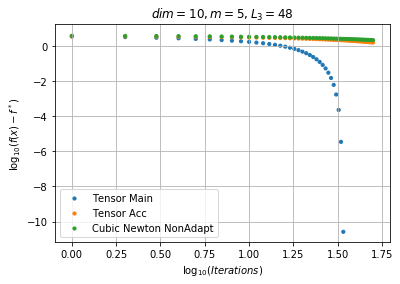

In [25]:
fig = plt.figure()
s = [10 for n in range(len(farr1) - 1)]

plt.xlabel(r'$\log_{10}(Iterations)$') 
plt.ylabel(r'$\log_{10}(f(x) - f^*)$') 
plt.title(r'$dim = {0}, m = {1}, L_3 = {2}$'.format(n, m, L3)) 

log_i = [np.log10(i) for i in range(1, NumIter + 1)]

plt.scatter(log_i, [np.log10(farr1[i] - fopt) for i in range(1, NumIter + 1)], label = 'Tensor Main', s = s)
#plt.scatter(log_i, [np.log10(farr2[i] - fopt) for i in range(1, NumIter + 1)], label = '2', s = s)
#plt.scatter(log_i, [np.log10(farr3[i] - fopt) for i in range(1, NumIter + 1)], label = '3', s = s)
plt.scatter(log_i, [np.log10(farr4[i] - fopt) for i in range(1, NumIter + 1)], label = 'Tensor Acc', s = s)
#plt.scatter(log_i, [np.log10(farr5[i] - fopt) for i in range(1, NumIter + 1)], label = '5', s = s)
#plt.scatter(log_i, [np.log10(farr6[i] - fopt) for i in range(1, NumIter + 1)], label = '6', s = s)
#plt.plot([i for i in range(NumIter + 1)], farr_fgm, label = 'FGM')
#plt.scatter(log_i, [np.log10(farr_newton_cubic_iter_ad[i] - fopt) for i in range(1, NumIter + 1)], 
#                                                                                label = 'Cubic Newton Adapt', s = s)
plt.scatter(log_i, [np.log10(farr_newton_cubic_iter_nd[i] - fopt) for i in range(1, NumIter + 1)], 
                                                                                label = 'Cubic Newton NonAdapt', s = s)

plt.legend()
plt.grid(True) 
fig.savefig('Scatter_Tensor3_f_L3={0}_iter.pdf'.format(L3))
plt.show()

##### Plot semilogy graphs

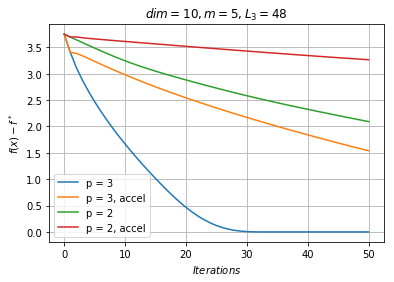

In [68]:
fig = plt.figure()

plt.xlabel(r'$Iterations$') 
plt.ylabel(r'$f(x) - f^*$') 
plt.title(r'$dim = {0}, m = {1}, L_3 = {2}$'.format(n, m, L3)) 

arr_i = [i for i in range(NumIter + 1)]

plt.plot(arr_i, farr1 - fopt, label = 'p = 3')
#plt.semilogy(arr_i, farr2 - fopt, label = '2')
#plt.semilogy(arr_i, farr3 - fopt, label = '3')
plt.plot(arr_i, farr4 - fopt, label = 'p = 3, accel')
#plt.semilogy(arr_i, farr5 - fopt, label = '5')
#plt.semilogy(arr_i, farr6 - fopt, label = '6')
#plt.plot([i for i in range(NumIter + 1)], farr_fgm, label = 'FGM')
#plt.semilogy(arr_i, farr_newton_cubic_iter_ad - fopt, label = 'Cubic Newton Adapt')
plt.plot(arr_i, farr_newton_cubic_iter_nd - fopt, label = 'p = 2')
plt.plot(arr_i, farr_newton_cubic_iter_nd_fast - fopt, label = 'p = 2, accel')

plt.legend()
plt.grid(True) 
fig.savefig('Tensor3_f_L3={0}_iter.pdf'.format(L3))
plt.show()

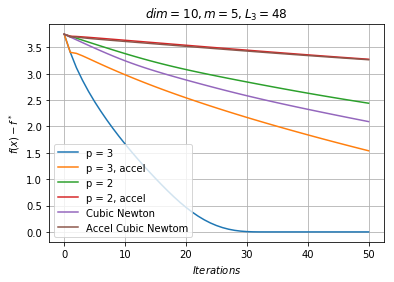

In [26]:
fig = plt.figure()

plt.xlabel(r'$Iterations$') 
plt.ylabel(r'$f(x) - f^*$') 
plt.title(r'$dim = {0}, m = {1}, L_3 = {2}$'.format(n, m, L3)) 

arr_i = [i for i in range(NumIter + 1)]

plt.plot(arr_i, farr1 - fopt, label = 'p = 3')
#plt.semilogy(arr_i, farr2 - fopt, label = '2')
#plt.semilogy(arr_i, farr3 - fopt, label = '3')
plt.plot(arr_i, farr4 - fopt, label = 'p = 3, accel')
plt.plot(arr_i, farr7 - fopt, label = 'p = 2')
plt.plot(arr_i, farr10 - fopt, label = 'p = 2, accel')
#plt.semilogy(arr_i, farr5 - fopt, label = '5')
#plt.semilogy(arr_i, farr6 - fopt, label = '6')
#plt.plot([i for i in range(NumIter + 1)], farr_fgm, label = 'FGM')
#plt.semilogy(arr_i, farr_newton_cubic_iter_ad - fopt, label = 'Cubic Newton Adapt')
plt.plot(arr_i, farr_newton_cubic_iter_nd - fopt, label = 'Cubic Newton')
plt.plot(arr_i, farr_newton_cubic_iter_nd_fast - fopt, label = 'Accel Cubic Newtom')

plt.legend()
plt.grid(True) 
fig.savefig('Tensors_f_L3={0}_iter.pdf'.format(L3))
plt.show()

##### Comparing versions of Accelerated tensor method

In [24]:
version = 1

aux_prob_method = 1
comp_xans1, comp_fans1, comp_farr1 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('1xans ', comp_xans1)
print('1fans, it1 ', comp_fans1, NumIter)

aux_prob_method = 2
comp_xans2, comp_fans2, comp_farr2 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('2xans ', comp_xans2)
print('2fans, it2 ', comp_fans2, NumIter)

aux_prob_method = 3
comp_xans3, comp_fans3, comp_farr3 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('3xans ', comp_xans3)
print('3fans, it3 ', comp_fans3, NumIter)

version = 2

aux_prob_method = 1
comp_xans4, comp_fans4, comp_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('4xans ', comp_xans4)
print('4fans, it4 ', comp_fans4, NumIter)

aux_prob_method = 2
comp_xans5, comp_fans5, comp_farr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('5xans ', comp_xans5)
print('5fans, it5 ', comp_fans5, NumIter)

aux_prob_method = 3
comp_xans6, comp_fans6, comp_farr6 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('6xans ', comp_xans6)
print('6fans, it6 ', comp_fans6, NumIter)

1xans  [ 2.40303027  1.56498556  0.89285637  0.3930751   0.07917307  0.          0.
  0.          0.          0.        ]
1fans, it1  -2.21066129642 50
2xans  [  2.40303027e+00   1.56498556e+00   8.92856366e-01   3.93075098e-01
   7.91730651e-02  -1.60628985e-08  -1.69230457e-08  -1.50327640e-08
  -1.50307634e-08  -1.06504566e-08]
2fans, it2  -2.21066129352 50
3xans  [ 2.40303028  1.56498556  0.89285637  0.3930751   0.07917307  0.          0.
  0.          0.          0.        ]
3fans, it3  -2.21066129799 50
4xans  [ 2.41328415  1.574522    0.90096478  0.39904248  0.08218198  0.          0.
  0.          0.          0.        ]
4fans, it4  -2.2196939849 50
5xans  [  2.41328415e+00   1.57452199e+00   9.00964771e-01   3.99042464e-01
   8.21819711e-02  -1.62341345e-08  -1.10442458e-08  -1.14485972e-08
  -1.13641948e-08  -1.54488216e-08]
5fans, it5  -2.21969398237 50
6xans  [ 2.41328415  1.574522    0.90096478  0.39904248  0.08218198  0.          0.
  0.          0.          0.        ]
6

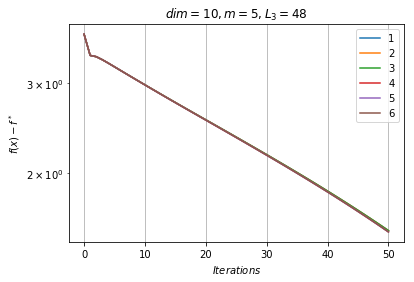

In [25]:
fig = plt.figure()

plt.xlabel(r'$Iterations$') 
plt.ylabel(r'$f(x) - f^*$') 
plt.title(r'$dim = {0}, m = {1}, L_3 = {2}$'.format(n, m, L3)) 

arr_i = [i for i in range(NumIter + 1)]

plt.semilogy(arr_i, comp_farr1 - fopt, label = '1')
plt.semilogy(arr_i, comp_farr2 - fopt, label = '2')
plt.semilogy(arr_i, comp_farr3 - fopt, label = '3')
plt.semilogy(arr_i, comp_farr4 - fopt, label = '4')
plt.semilogy(arr_i, comp_farr5 - fopt, label = '5')
plt.semilogy(arr_i, comp_farr6 - fopt, label = '6')

plt.legend()
plt.grid(True) 
fig.savefig('Comp_acc_Tensor3_f_L3={0}_iter.pdf'.format(L3))
plt.show()

# In this section we use $L_3 = 2^{p + 1} p!$ 

In [26]:
L3_big = Lp_2_norm_upper_bound_real(*args)
L2_big = L2_upper_bound(L3_big, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
bigL_xans1, bigL_fans1, bigL_farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
                x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_big, eps, aux_prob_method, *args)
print('1xans ', bigL_xans1)
print('1fans, it1 ', bigL_fans1, NumIter)

version = 1

aux_prob_method = 1
bigL_xans4, bigL_fans4, bigL_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_big, eps, aux_prob_method, version, *args)
print('4xans ', bigL_xans4)
print('4fans, it4 ', bigL_fans4, NumIter)

aux_prob_method = 2
bigL_xans5, bigL_fans5, bigL_farr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_big, eps, aux_prob_method, version, *args)
print('5xans ', bigL_xans5)
print('5fans, it5 ', bigL_fans5, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

adapt = 1
bigL_xans_newton_cubic_iter_ad, bigL_farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
bigL_xans_newton_cubic_iter_nd, bigL_farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2_big, eps, adapt, *args)
print('xans_newton_nonadapt ', bigL_xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', bigL_farr_newton_cubic_iter_nd[NumIter], NumIter)

1xans  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
1fans, it1  -3.75 50
4xans  [ 2.03756254  1.22369841  0.60152075  0.18174776  0.00705144  0.          0.
  0.          0.          0.        ]
4fans, it4  -1.88241957412 50
5xans  [  2.03756255e+00   1.22369842e+00   6.01520755e-01   1.81747764e-01
   7.05142618e-03  -5.05290977e-09  -4.31259955e-09  -4.30275463e-09
  -4.30360069e-09  -5.71332958e-09]
5fans, it5  -1.88241958717 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


xans_newton_adapt  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
xans_newton_adapt, it  -3.75 50
xans_newton_nonadapt  [  1.44493785e+00   6.23011463e-01   7.58280999e-02   6.56252423e-05
   1.53349800e-14   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
xans_newton_nonadapt, it  -1.30842174545 50


##### Plot semilogy graphs

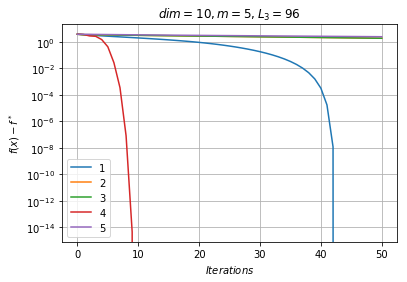

In [28]:
fig = plt.figure()

plt.xlabel(r'$Iterations$') 
plt.ylabel(r'$f(x) - f^*$') 
plt.title(r'$dim = {0}, m = {1}, L_3 = {2}$'.format(n, m, L3_big)) 

arr_i = [i for i in range(NumIter + 1)]

plt.semilogy(arr_i, bigL_farr1 - fopt, label = '1')
plt.semilogy(arr_i, bigL_farr4 - fopt, label = '2')
plt.semilogy(arr_i, bigL_farr5 - fopt, label = '3')
plt.semilogy(arr_i, bigL_farr_newton_cubic_iter_ad - fopt, label = '4')
plt.semilogy(arr_i, bigL_farr_newton_cubic_iter_nd - fopt, label = '5')

plt.legend()
plt.grid(True) 
fig.savefig('Tensor3_f_L3={0}_iter.pdf'.format(L3_big))
plt.show()

# In this section we use smaller $L_3 = 2 \cdot p!$ to compare with previous values

In [29]:
L3_small = Lp_2_norm_stupid(*args)
L2_small = L2_upper_bound(L3_small, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
smallL_xans1, smallL_fans1, smallL_farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_small, eps, aux_prob_method, *args)
print('1xans ', smallL_xans1)
print('1fans, it1 ', smallL_fans1, NumIter)

version = 1

aux_prob_method = 1
smallL_xans4, smallL_fans4, smallL_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_small, eps, aux_prob_method, version, *args)
print('4xans ', smallL_xans4)
print('4fans, it4 ', smallL_fans4, NumIter)

aux_prob_method = 2
smallL_xans5, smallL_fans5, smallL_farr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_small, eps, aux_prob_method, version, *args)
print('5xans ', smallL_xans5)
print('5fans, it5 ', smallL_fans5, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

adapt = 1
xans_newton_cubic_iter_ad, farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
smallL_xans_newton_cubic_iter_nd, smallL_farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2_small, eps, adapt, *args)
print('xans_newton_nonadapt ', smallL_xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', smallL_farr_newton_cubic_iter_nd[NumIter], NumIter)

1xans  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
1fans, it1  -3.75 50
4xans  [ 3.3132994   2.43135142  1.66729826  1.01832739  0.47371291  0.          0.
  0.          0.          0.        ]
4fans, it4  -2.99791717793 50
5xans  [  3.31329938e+00   2.43135140e+00   1.66729825e+00   1.01832738e+00
   4.73712904e-01  -2.40581555e-09  -2.82647759e-09  -4.14394630e-09
   2.89613025e-09  -3.51974505e-09]
5fans, it5  -2.99791716228 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


xans_newton_adapt  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
xans_newton_adapt, it  -3.75 50
xans_newton_nonadapt  [ 2.94368885  2.03461651  1.23569816  0.57595786  0.10787004  0.          0.
  0.          0.          0.        ]
xans_newton_nonadapt, it  -2.61170416694 50


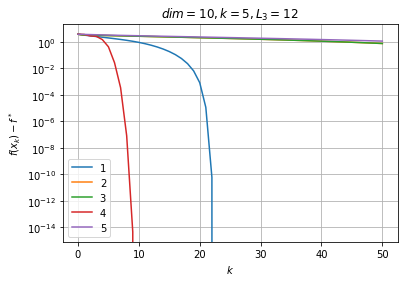

In [28]:
fig = plt.figure()

plt.xlabel(r'$Iterations$') 
plt.ylabel(r'$f(x) - f^*$') 
plt.title(r'$dim = {0}, m = {1}, L_3 = {2}$'.format(n, m, L3_small)) 

arr_i = [i for i in range(NumIter + 1)]

plt.semilogy(arr_i, smallL_farr1 - fopt, label = '1')
plt.semilogy(arr_i, smallL_farr4 - fopt, label = '2')
plt.semilogy(arr_i, smallL_farr5 - fopt, label = '3')
plt.semilogy(arr_i, farr_newton_cubic_iter_ad - fopt, label = '4')
plt.semilogy(arr_i, smallL_farr_newton_cubic_iter_nd - fopt, label = '5')

plt.legend()
plt.grid(True) 
fig.savefig('Tensor3_f_L3={0}_iter.pdf'.format(L3_small))
plt.show()

# Next problem and it's parametres, $n = 100$

In [141]:
n = 100
m = n // 2
NumIter = 50
TensorNumIter = 40
eps = 1e-7
tau = 1 + eps

x0 = np.zeros(n)
AuxMaxIter = 100
L0 = eps

p = 3
args = (m, n, p)

# In this and next section we use $L_3 = 2^p p!$ according to page $16$ in $[1]$.

In [142]:
L3 = Lp_2_norm_upper_bound_Nesterov(*args)
L2 = L2_upper_bound(L3, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
nbig_xans1, nbig_fans1, nbig_farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
print('1xans ', nbig_xans1)
print('1fans, it1 ', nbig_fans1, NumIter)

#aux_prob_method = 2
#xans2, fans2, farr2, fgradarr2 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
               #                 x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('2xans ', xans2)
#print('2fans, it2 ', fans2, NumIter)

#aux_prob_method = 3
#xans3, fans3, farr3, fgradarr3 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('3xans ', xans3)
#print('3fans, it3 ', fans3, NumIter)
version = 1

aux_prob_method = 1
nbig_xans4, nbig_fans4, nbig_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('4xans ', nbig_xans4)
print('4fans, it4 ', nbig_fans4, NumIter)

#aux_prob_method = 2
#xans5, fans5, farr5, fgradarr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('5xans ', xans5)
#print('5fans, it5 ', fans5, NumIter)

#aux_prob_method = 3
#xans6, fans6, farr6, fgradarr6 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('6xans ', xans6)
#print('6fans, it6 ', fans6, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f_true, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

aux_prob_method = 1
xans7, fans7, farr7 = Tensor2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                           aux_prob_method, *args)
print('7xans ', xans7)
print('7fans, it7 ', fans7, NumIter)

version = 1

aux_prob_method = 1
xans10, fans10, farr10 = TensorAcc2_iter(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                                     aux_prob_method, version, *args)
print('10xans ', xans10)
print('10fans, it10 ', fans10, NumIter)


nbig_xans_newton_cubic_iter_nd_fast, nbig_farr_newton_cubic_iter_nd_fast = fast_Newton_cubic_solver_iter(x0, 
                                                    NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2, eps, *args)
print('xans_newton_nonadapt_fast ', nbig_xans_newton_cubic_iter_nd_fast)
print('xans_newton_nonadapt_fast, it ', nbig_farr_newton_cubic_iter_nd_fast[NumIter], NumIter)

#adapt = 1
#xans_newton_cubic_iter_ad, farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
#                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
#print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
#print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
nbig_xans_newton_cubic_iter_nd, nbig_farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2, eps, adapt, *args)
print('xans_newton_nonadapt ', nbig_xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', nbig_farr_newton_cubic_iter_nd[NumIter], NumIter)

1xans  [  6.79555637e+000   5.83628087e+000   4.92123824e+000   4.05449976e+000
   3.24088545e+000   2.48625303e+000   1.79797893e+000   1.18584155e+000
   6.63905060e-001   2.55743258e-001   2.21093079e-002   8.93041370e-006
   2.29402412e-016   1.05436620e-049   6.26603991e-155   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.000

xans_newton_nonadapt  [  4.93444898e-001   1.55679065e-002   1.75601295e-007   9.21218366e-023
   3.97820539e-069   1.60578780e-209   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.000000

##### Plot scatter graphs

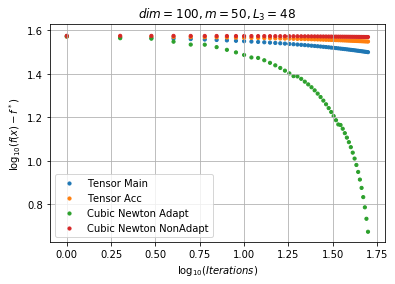

In [33]:
fig = plt.figure()
s = [10 for n in range(len(nbig_farr1) - 1)]

plt.xlabel(r'$\log_{10}(Iterations)$') 
plt.ylabel(r'$\log_{10}(f(x) - f^*)$') 
plt.title(r'$dim = {0}, m = {1}, L_3 = {2}$'.format(n, m, L3)) 

log_i = [np.log10(i) for i in range(1, NumIter + 1)]

plt.scatter(log_i, [np.log10(nbig_farr1[i] - fopt) for i in range(1, NumIter + 1)], label = 'Tensor Main', s = s)
plt.scatter(log_i, [np.log10(nbig_farr4[i] - fopt) for i in range(1, NumIter + 1)], label = 'Tensor Acc', s = s)
plt.scatter(log_i, [np.log10(farr_newton_cubic_iter_ad[i] - fopt) for i in range(1, NumIter + 1)], 
                                                                        label = 'Cubic Newton Adapt', s = s)
plt.scatter(log_i, [np.log10(nbig_farr_newton_cubic_iter_nd[i] - fopt) for i in range(1, NumIter + 1)], 
                                                                        label = 'Cubic Newton NonAdapt', s = s)

plt.legend()
plt.grid(True) 
fig.savefig('Scatter_Tensor3_f_n={0}_iter.pdf'.format(n))
plt.show()

##### Plot graphs

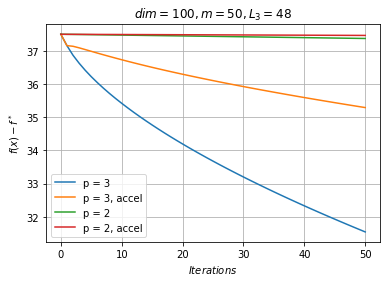

In [143]:
fig = plt.figure()

plt.xlabel(r'$Iterations$') 
plt.ylabel(r'$f(x) - f^*$') 
plt.title(r'$dim = {0}, m = {1}, L_3 = {2}$'.format(n, m, L3)) 

arr_i = [i for i in range(NumIter + 1)]

plt.plot(arr_i, nbig_farr1 - fopt, label = 'p = 3')
plt.plot(arr_i, nbig_farr4 - fopt, label = 'p = 3, accel')
plt.plot(arr_i, farr7 - fopt, label = 'p = 2')
plt.plot(arr_i, farr10 - fopt, label = 'p = 2, accel')
#plt.plot(arr_i, nbig_farr_newton_cubic_iter_nd - fopt, label = 'Cubic Newton')
#plt.plot(arr_i, nbig_farr_newton_cubic_iter_nd_fast - fopt, label = 'Accel Cubic Newtom')


plt.legend()
plt.grid(True) 
fig.savefig('Tensors_f_n={0}_iter.pdf'.format(n))
plt.show()

##### Saving data

In [144]:
np.savetxt('farr_tensor_3_n=100.txt', nbig_farr1 - fopt)
np.savetxt('farr_tensor3_acc_n=100.txt', nbig_farr4 - fopt)
np.savetxt('farr_tensor2_n=100.txt', farr7 - fopt)
np.savetxt('farr_tensor2_acc_n=100.txt', farr10 - fopt)

# Last problem for $f_k$ and it's parametres, $n = 1000$

In [113]:
n = 1000
k = n // 2
NumIter = 50
TensorNumIter = 40
eps = 1e-7
tau = 1 + eps

x0 = np.zeros(n)
AuxMaxIter = 100
L0 = eps

p = 3
args = (k, n, p)

##### Tensor method $[1]$.$[2.16]$ and accelerated tensor method $[1]$.$[3.12]$ by Yu. Nesterov (2018), $p = 2$ with history printing

In [112]:
def Tensor2_iter_hist(NumIter, AuxMaxIter, x0, f, grad_f, hess_f, tau, L2, eps, aux_prob_method, *args):
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    xk = copy.deepcopy(x0)

    for k in range(NumIter):
        f_xk = f(xk, *args)
        print('iter = {0}, f_k = {1}'.format(k, f_xk))
        grad_f_cur = grad_f(xk, *args)
        hess_f_cur = hess_f(xk, *args)
        farr[k] = f_xk
        #fgradarr[k] = linalg.norm(grad_f_xk)
        xk = T2M(xk, aux_prob_method, grad_f_cur, hess_f_cur, AuxMaxIter, tau, L2, eps, *args)
        
    f_xk = f(xk, *args)
    #grad_f_xk = grad_f(xk, *args)
    farr[NumIter] = f_xk
    print('iter = {0}, f_k = {1}'.format(NumIter, f_xk))
    #fgradarr[NumIter] = linalg.norm(grad_f_xk)
    
    return xk, f_xk, farr#, fgradarr

def TensorAcc2_iter_hist(NumIter, AuxMaxIter, x0, f, grad_f, hess_f, tau, L2, eps, aux_prob_method, version, *args):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L2
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    
    
    f_xk = f(xk, *args)
    farr[0] = f_xk
    print('iter = {0}, f_k = {1}'.format(0, f_xk))
    grad_f_xk = grad_f(xk, *args)
    #fgradarr[0] = linalg.norm(grad_f_xk)
    hessian_f_xk = hess_f(xk, *args)
  
    xk = T2M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, AuxMaxIter, tau, L2, eps, *args)  
    #print('xk = {0}'.format(xk))
    f_xk = f(xk, *args)
    print('iter = {0}, f_k = {1}'.format(1, f_xk))
    #gradf_xk = grad_f(xk, *args)
    farr[1] = f_xk
    #fgradarr[1] = linalg.norm(gradf_xk)
    
    p = 2
    C = p / 2 * math.sqrt((p + 1)/(p - 1)*(M*M - L2*L2))
    
    min_psik = copy.deepcopy(x0)
    n = x0.shape[0]
    sk = np.zeros(n)
    if (version == 1):
        ak_part = math.sqrt(pow((p - 1) * (M*M - L2*L2) / 4 / (p + 1) / M / M, p))
    elif (version == 2):
        ak_part = math.sqrt(pow((p + 1) * (M*M - L2*L2) / 4 / (p - 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        #print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        #print('yk = {0}'.format(yk))
        grad_f_yk = grad_f(yk, *args)
        hessian_f_yk = hess_f(yk, *args)

        xk = T2M(yk, aux_prob_method, grad_f_yk, hessian_f_yk, AuxMaxIter, tau, L2, eps, *args)        
        #print('xk = {0}'.format(xk))
        grad_next = grad_f(xk, *args)
        a = Ak1 - Ak
        sk = sk + a * grad_next 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk, *args)
        print('iter = {0}, f_k = {1}'.format(k + 1, f_xk))
        farr[k + 1] = f_xk
        #fgradarr[k + 1] = linalg.norm(grad_next)
    
    return xk, f_xk, farr#, fgradarr, k

In [114]:
L3 = Lp_2_norm_upper_bound_Nesterov(*args)
L2 = L2_upper_bound(L3, x0, *args)
L2

620606.77405262028

# Computing methods $[1]$.$[2.16]$ and $[1]$.$[3.12]$ with $p = 2$ by testing on $[1]$.$[4.3]$ with $n = 1000$

In [115]:
L3 = Lp_2_norm_upper_bound_Nesterov(*args)
L2 = L2_upper_bound(L3, x0, *args)
fopt = f_opt(*args)

#adapt = 1
#xans_newton_cubic_iter_ad, farr_newton_cubic_iter_ad = Newton_cubic_solver_iter_hist(x0,
#                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
#print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
#print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

aux_prob_method = 1
t2_xans, t2_fans, t2_farr = Tensor2_iter_hist(NumIter, AuxMaxIter, x0, f, grad_f_true, hess_f_true, tau, L2, eps, 
                                                           aux_prob_method, *args)
print('t2_xans ', t2_xans)
print('t2_fans, it ', t2_fans, NumIter)

version = 1

aux_prob_method = 1
t2_acc_xans, t2_acc_fans, t2_acc_farr = TensorAcc2_iter_hist(NumIter, AuxMaxIter, x0, f, grad_f_true, 
                                        hess_f_true, tau, L2, eps, aux_prob_method, version, *args)
print('t2_acc_xans ', t2_acc_xans)
print('t2_acc_fans, it ', t2_acc_fans, NumIter)

iter = 0, f_k = 0.0
iter = 1, f_k = -2.6311242144478924e-06
iter = 2, f_k = -5.262248428895785e-06
iter = 3, f_k = -7.893372643343675e-06
iter = 4, f_k = -1.0524496857791563e-05
iter = 5, f_k = -1.3155621072239446e-05
iter = 6, f_k = -1.578674528668732e-05
iter = 7, f_k = -1.8417869501135185e-05
iter = 8, f_k = -2.1048993715583035e-05
iter = 9, f_k = -2.3680117930030863e-05
iter = 10, f_k = -2.631124214447867e-05
iter = 11, f_k = -2.894236635892644e-05
iter = 12, f_k = -3.157349057337418e-05
iter = 13, f_k = -3.420461478782188e-05
iter = 14, f_k = -3.6835739002269524e-05
iter = 15, f_k = -3.9466863216717105e-05
iter = 16, f_k = -4.2097987431164626e-05
iter = 17, f_k = -4.4729111645612065e-05
iter = 18, f_k = -4.736023586005942e-05
iter = 19, f_k = -4.999136007450669e-05
iter = 20, f_k = -5.262248428895385e-05
iter = 21, f_k = -5.525360850340089e-05
iter = 22, f_k = -5.78847327178478e-05
iter = 23, f_k = -6.051585693229456e-05
iter = 24, f_k = -6.314698114674117e-05
iter = 25, f_k = -6.

iter = 1, f_k = -2.6311242144478924e-06
iter = 2, f_k = -2.960014741253879e-06
iter = 3, f_k = -7.056362479941466e-06
iter = 4, f_k = -1.1225969438001126e-05
iter = 5, f_k = -1.576056401453942e-05
iter = 6, f_k = -2.069243475778444e-05
iter = 7, f_k = -2.600852912961403e-05
iter = 8, f_k = -3.1687992150704146e-05
iter = 9, f_k = -3.771025946951613e-05
iter = 10, f_k = -4.405680255186806e-05
iter = 11, f_k = -5.071129745579138e-05
iter = 12, f_k = -5.765940184796885e-05
iter = 13, f_k = -6.488846478411788e-05
iter = 14, f_k = -7.238725827744423e-05
iter = 15, f_k = -8.014575033861181e-05
iter = 16, f_k = -8.815491870221461e-05
iter = 17, f_k = -9.640659919880579e-05
iter = 18, f_k = -0.00010489336222849407
iter = 19, f_k = -0.00011360841163870076
iter = 20, f_k = -0.0001225455013922087
iter = 21, f_k = -0.00013169886639225628
iter = 22, f_k = -0.00014106316463149748
iter = 23, f_k = -0.0001506334284582133
iter = 24, f_k = -0.00016040502323580935
iter = 25, f_k = -0.00017037361204151358


##### Saving data

In [117]:
np.savetxt('tensor2_result.txt', t2_farr)
np.savetxt('tensor2_acc_result.txt', t2_acc_farr)